## Stability of the Grid System

Electrical grids require a balance between electricity supply and demand in order to be stable. Conventional systems achieve this balance through demand-driven electricity production. For future grids with a high share of inflexible (i.e., renewable) energy sources, the concept of demand response is a promising solution. This implies changes in electricity consumption in relation to electricity price changes. In this work, we’ll build a binary classification model to predict if a grid is stable or unstable using the UCI Electrical Grid Stability Simulated dataset.

In [1]:
#!pip install imblearn
#!pip install category_encoders

## Import Libraries

In [2]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from zipfile import ZipFile
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, classification_report


%matplotlib inline
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

## Get and Load data

In [3]:
!wget https://archive.ics.uci.edu/static/public/471/electrical+grid+stability+simulated+data.zip

--2023-07-04 15:30:46--  https://archive.ics.uci.edu/static/public/471/electrical+grid+stability+simulated+data.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘electrical+grid+stability+simulated+data.zip’

electrical+grid+sta     [ <=>                ]   2.31M   169KB/s    in 14s     

2023-07-04 15:31:02 (167 KB/s) - ‘electrical+grid+stability+simulated+data.zip’ saved [2418013]



In [4]:
# Extract from zip
filename = "electrical+grid+stability+simulated+data.zip"
zip = ZipFile(filename, 'r')
zip.extractall('./data')
os.remove(filename)

In [5]:
%%bash
cd ./data
ls

Data_for_UCI_named.csv


In [6]:
# Make dataframe
data = pd.read_csv('./data/Data_for_UCI_named.csv')

## Inspect data

In [7]:
data.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable


In [8]:
data.shape

(10000, 14)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tau1    10000 non-null  float64
 1   tau2    10000 non-null  float64
 2   tau3    10000 non-null  float64
 3   tau4    10000 non-null  float64
 4   p1      10000 non-null  float64
 5   p2      10000 non-null  float64
 6   p3      10000 non-null  float64
 7   p4      10000 non-null  float64
 8   g1      10000 non-null  float64
 9   g2      10000 non-null  float64
 10  g3      10000 non-null  float64
 11  g4      10000 non-null  float64
 12  stab    10000 non-null  float64
 13  stabf   10000 non-null  object 
dtypes: float64(13), object(1)
memory usage: 1.1+ MB


In [10]:
data.nunique()

tau1     10000
tau2     10000
tau3     10000
tau4     10000
p1       10000
p2       10000
p3       10000
p4       10000
g1       10000
g2       10000
g3       10000
g4       10000
stab     10000
stabf        2
dtype: int64

In [11]:
data.isna().sum()

tau1     0
tau2     0
tau3     0
tau4     0
p1       0
p2       0
p3       0
p4       0
g1       0
g2       0
g3       0
g4       0
stab     0
stabf    0
dtype: int64

In [12]:
## Make working copy
working = data.copy()

In [13]:
working['stabf'] = np.where(working['stabf'] == 'unstable',0, 1)

In [14]:
working.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,0
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,1
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,0
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,0
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,0


## Requirements
1. Because of the direct relationship between 'stab' and 'stabf' ('stabf' = 'stable' if 'stab' <= 0, 'unstable' otherwise), 'stab' should be dropped and 'stabf' will remain as the sole dependent variable (binary classification).
2. Split the data into an 80-20 train-test split with a random state of “1”.
3. Use the standard scaler to transform the train set (x_train, y_train) and the test set (x_test).
4. Use scikit learn to train a random forest and extra trees classifier.
5. Use xgboost and lightgbm to train an extreme boosting model and a light gradient boosting model.

**Use random_state = 1 for training all models and evaluate on the test set.**

In [15]:
# Drop stab
working = working.drop('stab', axis=1)
working.columns

Index(['tau1', 'tau2', 'tau3', 'tau4', 'p1', 'p2', 'p3', 'p4', 'g1', 'g2',
       'g3', 'g4', 'stabf'],
      dtype='object')

In [16]:
# Make feature and target matrix
target = 'stabf'
X = working.drop(columns=target)
y = working[target]

# Train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1)

# Print shapes
print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

X_train: (8000, 12)
X_test: (2000, 12)
y_train: (8000,)
y_test: (2000,)


In [17]:
## Make pipelines for the models

# Random Forest
rand_model = make_pipeline(
    StandardScaler(), RandomForestClassifier(random_state=1)
)

# Extra Trees Classifier
extra_model = make_pipeline(
    StandardScaler(), ExtraTreesClassifier(random_state=1)
)


#XG Boost
xg_model = make_pipeline(
    StandardScaler(), XGBClassifier(random_state=1)
)

# Light GBM
lgb_model = make_pipeline(
    StandardScaler(), LGBMClassifier(random_state=1)
)

# Fit models
rand_model.fit(X_train, y_train)
extra_model.fit(X_train, y_train)
xg_model.fit(X_train, y_train)
lgb_model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lgbmclassifier', LGBMClassifier(random_state=1))])

#### Performance on Train set

In [18]:
## Performance on Train Set
models = [rand_model, extra_model, xg_model, lgb_model]

model_names = ['Random Forest', 'Extra Trees', 'XG Boost', 'Light GBM']
train_scores = []
for model in models:
    y_pred = model.predict(X_train)
    score = accuracy_score(y_train, y_pred)
    train_scores.append(score)
    

pd.Series(train_scores, index=model_names).sort_values()

Light GBM        0.997875
Random Forest    1.000000
Extra Trees      1.000000
XG Boost         1.000000
dtype: float64

#### Performance on Test Set

In [19]:
## Performance on Test Set

test_scores = []
for model in models:
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    test_scores.append(score)
    

pd.Series(test_scores, index=model_names).sort_values()

Extra Trees      0.9285
Random Forest    0.9295
Light GBM        0.9395
XG Boost         0.9455
dtype: float64

### Task
Using the ExtraTreesClassifier as your estimator with cv=5, n_iter=10, scoring = 'accuracy', n_jobs = -1, verbose = 1 and random_state = 1. What are the best hyperparameters from the randomized search CV?

In [20]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 300, 500, 1000],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [4, 6, 8],
    'max_features': ['auto', 'log2', None],
}

# Create the ExtraTreesClassifier estimator
estimator = ExtraTreesClassifier()

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator, param_grid, cv=5, n_iter=10, scoring='accuracy', n_jobs=-1, verbose=1, random_state=1)

# Fit
random_search.fit(X_train, y_train) 

# Access the best hyperparameters
best_params = random_search.best_params_
print(best_params)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': None}


### Task
Train a new ExtraTreesClassifier Model with the new Hyperparameters from the RandomizedSearchCV (with random_state = 1). Is the accuracy of the new optimal model higher or lower than the initial ExtraTreesClassifier model with no hyperparameter tuning?

In [21]:
e_tree = make_pipeline(StandardScaler(), ExtraTreesClassifier(
    n_estimators = 500, min_samples_split = 5, min_samples_leaf = 6, max_features= None
)
                      )
e_tree.fit(X_train, y_train)
print(f'Train_score: {model.score(X_train, y_train)}')
print(f'Test_score: {model.score(X_test, y_test)}')

Train_score: 0.997875
Test_score: 0.9395


**Observation:**
- Train Score Lower than initial train score of 1
- Test score higher than initial score of 0.9285

### Task
Find the feature importance using the optimal ExtraTreesClassifier model. Which features are the most and least important respectively?

In [22]:
importances = e_tree.named_steps['extratreesclassifier'].feature_importances_
features = e_tree.named_steps['standardscaler'].get_feature_names_out()

feat_imp = pd.Series(importances, index=features).sort_values()

In [23]:
# Least Important
feat_imp.head(1)

p1    0.005265
dtype: float64

In [24]:
# Most important
feat_imp.tail(1)

tau2    0.138397
dtype: float64

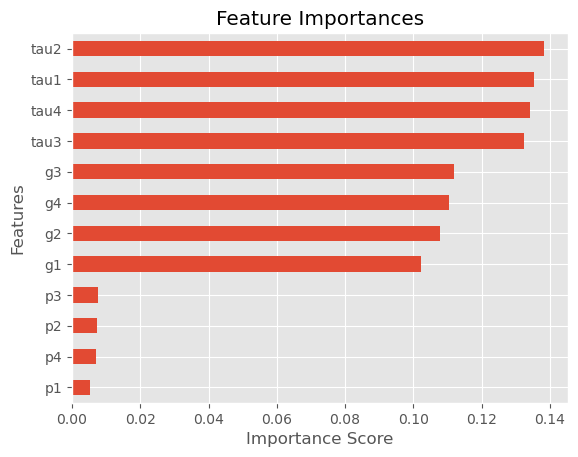

In [25]:
feat_imp.plot(kind = 'barh',
                     title = 'Feature Importances',
                     xlabel = 'Importance Score',
                     ylabel = 'Features')
plt.show()